### Load Data

In [ ]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("canonwu/mnistpkl")

print("Path to dataset files:", path)

/mnt/anaconda3/envs/vae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 32.9M/32.9M [00:02<00:00, 16.6MB/s]

Extracting files...


Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/canonwu/mnistpkl/versions/1


In [7]:
#Load MNIST
from torchvision.datasets import MNIST
import numpy as np

# Load train and test datasets
train_dataset = MNIST(root="./data", train=True, download=True)
test_dataset = MNIST(root="./data", train=False, download=True)

# Extract image data from both sets and convert to NumPy arrays
train_images = np.stack([np.array(img, dtype=np.uint8) for img, _ in train_dataset])  # (60000, 28, 28)
test_images = np.stack([np.array(img, dtype=np.uint8) for img, _ in test_dataset])    # (10000, 28, 28)

# Combine into one variable
all_images = np.concatenate([train_images, test_images], axis=0)  # (70000, 28, 28)

In [ ]:
all_images.shape

(70000, 28, 28)

In [2]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [3]:
import numpy as np

In [4]:
for t in train_dataset:
    print(t)
    break

(<PIL.Image.Image image mode=L size=28x28 at 0x7FD029EA74C0>, 5)


In [5]:
t[0]

### Plot Training Loss

In [51]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
save_path = "./output/model"
loss_per_epoch = {}

for epoch_num in tqdm(range(len(os.listdir(save_path)))):

    file_path = os.path.join(save_path, f"new_model_epoch_{epoch_num}.pt")

    d = torch.load(file_path)
    loss_per_epoch[d["epoch"]] = d["loss"].detach().cpu().numpy()

100%|██████████| 899/899 [00:23<00:00, 37.96it/s]


In [5]:
import numpy as np

In [10]:
np.isnan(loss_per_epoch[800])

True

In [11]:
nan_vals = [e for e, l in loss_per_epoch.items() if np.isnan(l)]

In [13]:
min(nan_vals)

723

In [15]:
loss_per_epoch[722]

array(179.61365, dtype=float32)

Text(0, 0.5, 'Loss')

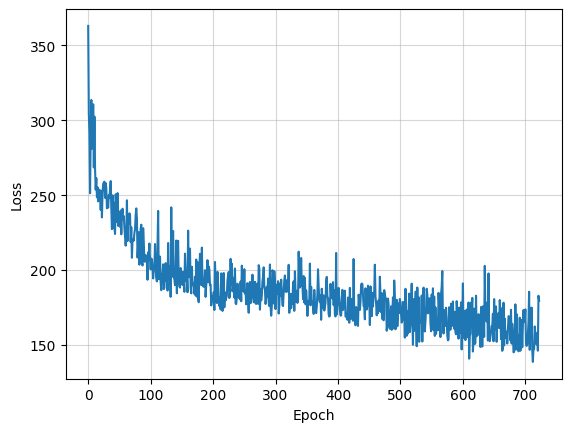

In [14]:
plt.plot(loss_per_epoch.keys(), loss_per_epoch.values())
plt.grid(True, alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Removing the state dict from log files

In [28]:
import os
import shutil
from tqdm import tqdm
import torch

In [46]:
log_path = "/mnt/TD-VAE/output/model"

# for epoch in tqdm(range(len(os.listdir(log_path)))):
for epoch in tqdm(range(900)):

    file_path = os.path.join(log_path, f"new_model_epoch_{epoch}.pt")
    # print(file_path)
    
    if (epoch % 100 == 0) and (epoch > 0): 
        continue

    if epoch > 725:
        if os.path.exists(file_path): os.remove(file_path)
        continue

    info = torch.load(file_path)
    # print(info.keys())



    if ("model_state_dict" in info.keys()) or ("optimizer_state_dict" in info.keys()):
        info_filt = {"epoch": info["epoch"], "loss": info["loss"]}
        torch.save(info_filt, file_path)

100%|██████████| 900/900 [00:00<00:00, 5547.77it/s]


'/mnt/TD-VAE/output/model/new_model_epoch_849.pt'

### Plotting

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

import numpy as np
import torch
from tqdm import tqdm

import random
import torch
import torch.nn as nn
import math
import torch
import random
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MovingMNIST_old(torch.utils.data.Dataset):
    def __init__(self, num_sequences=10000, sequence_length=20, image_size=32, digit_size=28, speed=2, digit=99):
        self.mnist = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        self.num_sequences = num_sequences
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.digit_size = digit_size
        self.speed = speed  # pixels/frame
        self.digit = digit

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        canvas_size = self.image_size #32x32 looks similiar as in paper increase if required
        frames = np.zeros((self.sequence_length, canvas_size, canvas_size), dtype=np.float32)

        # Select a random MNIST digit
        #digit_img, _ = self.mnist[random.randint(0, len(self.mnist) - 1)] #Random
        digit_img, label = self.mnist[random.randint(0, len(self.mnist) - 1)]

        if self.digit in range(0,10):
        # Uncomment the following line to select only a specific digit (e.g., 3) for testing
            while label != self.digit: digit_img, label = self.mnist[random.randint(0, len(self.mnist) - 1)]
            digit_img = digit_img.squeeze(0).numpy()

        else:
            digit_img = digit_img.squeeze(0).numpy()

        if self.speed in range(0,5):
            self.speed = self.speed

        else:
            self.speed = random.randint(1,4)



        # Random direction: -1 (left) or +1 (right)
        #direction = random.choice([-1, 1]) direction controlled by the training


        direction = 1
        direction = random.choice([-1, 1]) #direction controlled by the training

        dx = direction * self.speed  # no of pixel left/right

        # Random start
        x = random.randint(0, canvas_size - self.digit_size)
        y = random.randint(0, canvas_size - self.digit_size)
        #y = (canvas_size - self.digit_size) // 2  # center vertically if needed

        for t in range(self.sequence_length):
            x_int = int(np.floor(x)) % canvas_size  # wrap x using modulo

            # Handle wrap-around drawing
            if x_int + self.digit_size <= canvas_size:
                # Fully inside canvas
                frames[t, y:y+self.digit_size, x_int:x_int + self.digit_size] += digit_img
            else:
                # Split across right and left border
                right_part = canvas_size - x_int
                left_part = self.digit_size - right_part

                # Right slice
                frames[t, y:y+self.digit_size, x_int:] += digit_img[:, :right_part]
                # Left slice
                frames[t, y:y+self.digit_size, :left_part] += digit_img[:, right_part:]

            x += dx  # move with wrapping

        frames = np.clip(frames, 0, 1)
        frames = torch.tensor(frames).unsqueeze(1)  # shape: (T, 1, H, W)
        return frames.to(device)

class MovingMNIST(torch.utils.data.Dataset):
    def __init__(self, num_sequences=10000, sequence_length=20, image_size=28, digit_size=28, speed=2, digit=99):
        self.mnist = MNIST(root='/mnt/TD-VAE/data', train=True, download=True, transform=transforms.ToTensor())
        self.num_sequences = num_sequences
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.digit_size = digit_size
        self.speed = speed  # pixels/frame
        self.digit = digit

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        canvas_size = self.image_size #32x32 looks similiar as in paper increase if required
        frames = np.zeros((self.sequence_length, canvas_size, canvas_size), dtype=np.float32)   #Shape: (20, 32, 32)

        digit_img, _ = self.mnist[idx]       #Shape: (1, 28, 28)
        digit_img = digit_img[0]             #Shape: (28, 28)

        if self.speed not in range(0,5):
            self.speed = random.randint(1,4)

        # Random direction: -1 (left) or +1 (right)
        direction = random.choice([-1, 1]) #direction controlled by the training
        dx = direction * self.speed  # no of pixel left/right

        for t in range(self.sequence_length):
            frames[t] = np.roll(digit_img, shift=t * dx, axis=1)

        ###TODO CHECK
        fig, ax = plt.subplots(1, 20, figsize=(15, 8))

        for t in range(20):
            ax[t].imshow(frames[t])

        plt.show()      

        ####

        frames = torch.tensor(frames).unsqueeze(1)  # shape: (T, 1, H, W)
        return frames
    
def show_sequence(frames, title="Wrapped Digit Movement"):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 1.5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i, 0], cmap="gray")
        ax.axis("off")
    #plt.suptitle(title)
    plt.show()

def time_interval():
    """
    Choose a random t1 in [1,19]
    Choose a random dt between 1 and 4
    Choose random direction +/-1
    Compute t2 = t1 + dt * direction
    Clip t2 to stay within [0,20]
    """
    t1 = random.randint(1, 18)
    dt = random.randint(1, 4)
    direction = random.choice([-1, 1])
    direction = 1  # TODo: Try for both left and right
    t2 = t1 + dt * direction

    # Border check: clip to [0, 20]
    if t2 < 0:
        t2 = 0
    elif t2 > 19:
        t2 = 19

    return t1, t2, direction


In [29]:
x_train = MovingMNIST(num_sequences=6, sequence_length=20, speed = 3, digit = 10)
#train_loader = DataLoader(x_train, batch_size=1, shuffle=True)
x_train

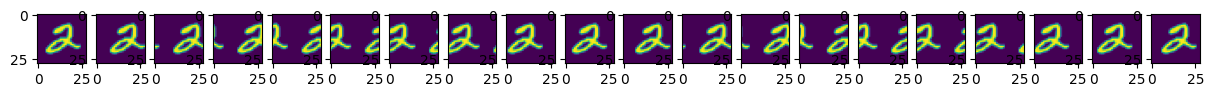

In [30]:
check = x_train.__getitem__(5)

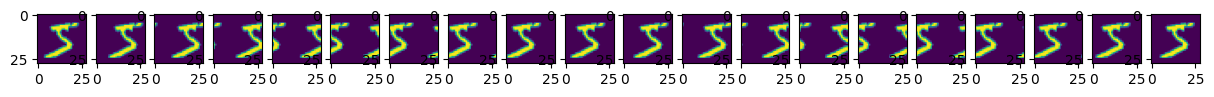

In [31]:
check = x_train.__getitem__(0)

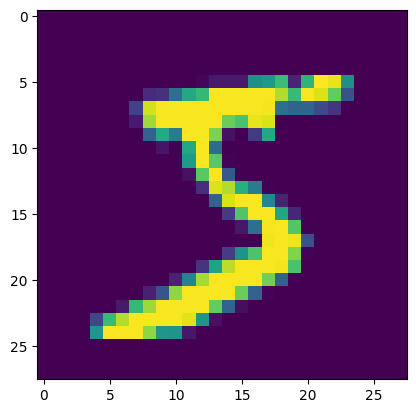

In [22]:
img = x_train.mnist[0][0][0]
plt.imshow(img)

In [4]:
img.shape

torch.Size([28, 28])

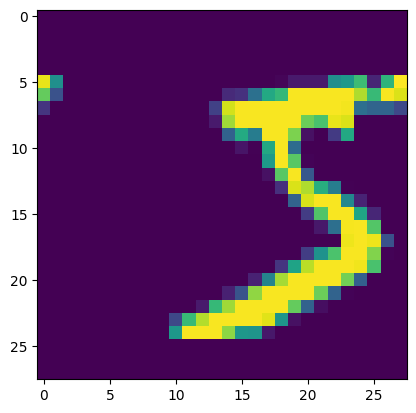

In [10]:
img_roll = np.roll(img, shift=6, axis = 1)
plt.imshow(img_roll)

In [37]:
x_train[0].shape

torch.Size([20, 1, 32, 32])

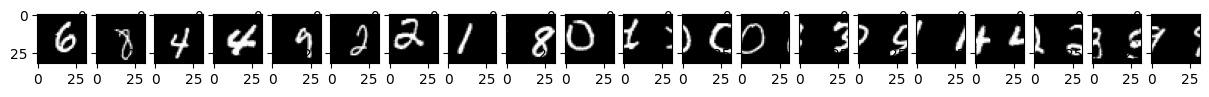

In [ ]:
import matplotlib.pyplot as plt
from itertools import islice

fig, ax = plt.subplots(1, 20, figsize=(15, 5))

# for i, img in enumerate(x_train[100]):
#     # print(img.shape)
#     # print(img.dtype)
#     ax[i].imshow(img[0].detach().cpu().numpy(), cmap="gray")

# batch_id = 100
# for count in range(20):
#     # print(img.shape)
#     # print(img.dtype)
#     x_batch = x_train[100]  #Shape: (20, 1, H, W)
#     img = x_batch[count]
#     ax[count].imshow(img[0].detach().cpu().numpy(), cmap="gray")


# batch_id = 20
# for count in range(20):
#     x_batch = next(islice(train_loader, batch_id, None), None)[batch_id]
#     img = x_batch[count]
#     ax[count].imshow(img[0].detach().cpu().numpy(), cmap="gray")

# for batch in train_loader:
#     for count in range(20):

#         # print(batch.shape)

#         x_batch = batch[5]  #Shape: (20, 1, 32, 32)
#         img = x_batch[count]
#         ax[count].imshow(img[0].detach().cpu().numpy(), cmap="gray")

#     break

### Plot Loss Curve

In [52]:
import numpy as np
import matplotlib.pyplot as plt


In [40]:
# path = "/mnt/TD-VAE/Elsa/Clean/default_old_kl_git_loss/loss_per_epoch.txt"
# path = "/mnt/TD-VAE/Elsa/Clean/default_old_kl/loss_per_epoch.txt"
# path = "/mnt/TD-VAE/Elsa/Clean/default_old_kl_git_loss_batch_256/loss_per_epoch.txt"
# path = "/mnt/TD-VAE/Elsa/Clean/default_old_kl_batch_256/loss_per_epoch.txt"

path = "/mnt/TD-VAE/Elsa/Clean/default_bce_speed_9/loss_per_epoch.txt"

with open(path, "r") as f:
    data = f.readlines()

len(data)

60

In [41]:
data[0]

'0, 328.99462657863813, 321.7768425375728, 3.098444029436273\n'

In [42]:
loss = {}
for line in data:
    
    s = line.strip()
    s_split = s.split(",")
    
    epoch_num = int(s_split[0])
    total_loss = float(s_split[1])
    rec_loss = float(s_split[2])
    kl_loss = float(s_split[3])

    loss[epoch_num] = {"total_loss": total_loss, "rec_loss": rec_loss, "kl_loss": kl_loss}


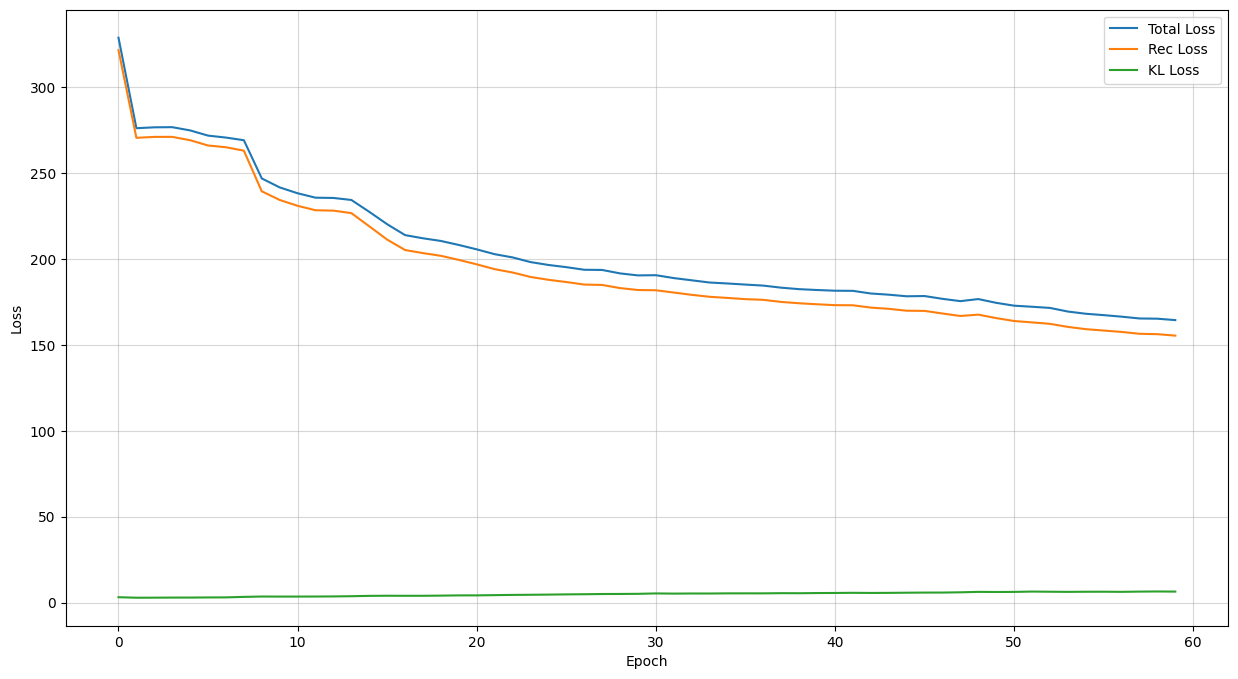

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax.plot(loss.keys(), [loss[k]["total_loss"] for k in loss.keys()], label="Total Loss")
ax.plot(loss.keys(), [loss[k]["rec_loss"] for k in loss.keys()], label="Rec Loss")
ax.plot(loss.keys(), [loss[k]["kl_loss"] for k in loss.keys()], label = "KL Loss")

plt.grid(True, alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#fig.savefig("/mnt/TD-VAE/Elsa/Clean/default_bce_speed_9/loss.png")

### Plotting Git guy's loss

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

/mnt/anaconda3/envs/vae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
dir_path = "/mnt/TD-VAE/output/model_with_kl"

loss = {}
for epoch_num in range(len(os.listdir(dir_path))):

    file_path = os.path.join(dir_path, f"new_model_epoch_{epoch_num}.pt")

    info = torch.load(file_path)

    loss[info["epoch"]] = {"total_loss": info["loss"].detach().cpu().item(), 
                           "kl_loss": info["kl_loss"].detach().cpu().item()}

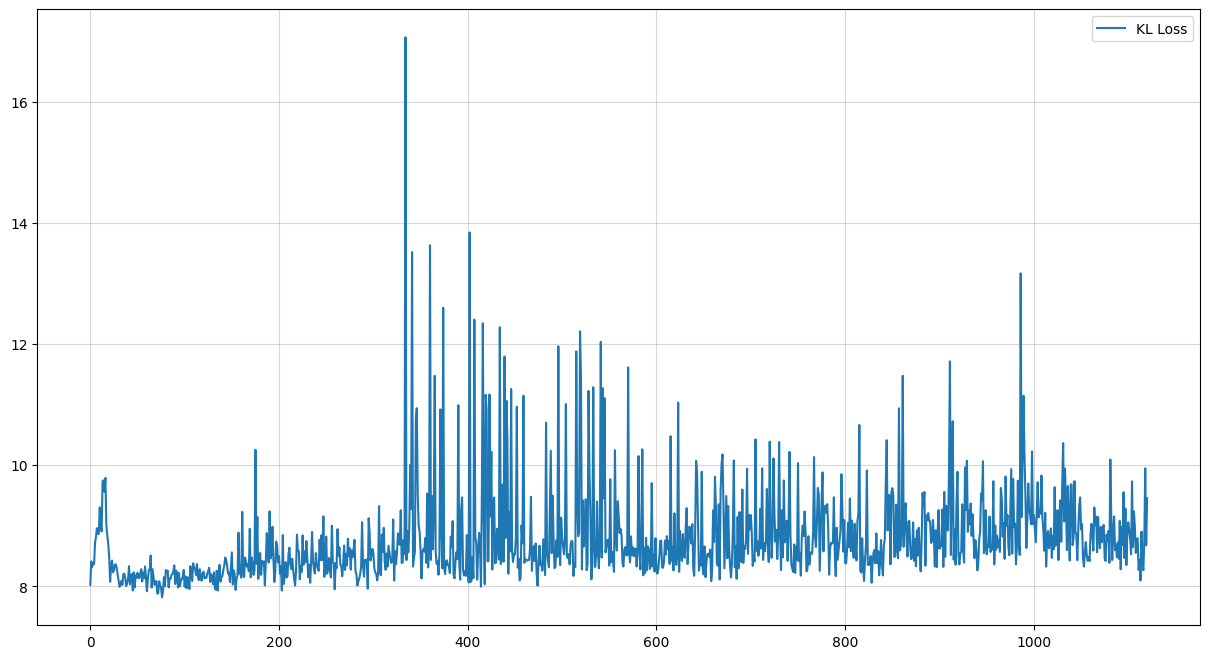

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

#ax.plot(loss.keys(), [loss[k]["total_loss"] for k in loss.keys()], label="Total Loss")
ax.plot(loss.keys(), [loss[k]["kl_loss"] for k in loss.keys()], label="KL Loss")
plt.legend()
plt.grid(True, alpha=0.5)